<a href="https://colab.research.google.com/github/ahdelrawy/3D-segmentation/blob/main/Team15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/heart-segmentation-in-ct-images")

print("Path to dataset files:", path)

100%|██████████| 708M/708M [00:08<00:00, 87.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/heart-segmentation-in-ct-images/versions/2


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/heart-segmentation-in-ct-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heart-segmentation-in-ct-images' dataset.
Path to dataset files: /kaggle/input/heart-segmentation-in-ct-images


Image shape: (110, 320, 320)
Mask shape: (110, 320, 320)


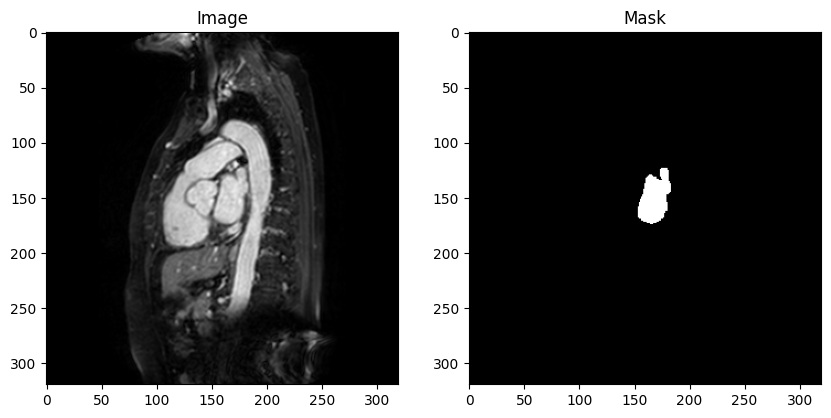

In [ ]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt

# اقرأ الملفات
case_path = os.path.join(path, "Training Set", "a010")
img = sitk.ReadImage(os.path.join(case_path, "image.mhd"))
mask = sitk.ReadImage(os.path.join(case_path, "gt_binary.mhd"))

# حول ل numpy
img_arr = sitk.GetArrayFromImage(img)
mask_arr = sitk.GetArrayFromImage(mask)

print("Image shape:", img_arr.shape)
print("Mask shape:", mask_arr.shape)

# عرض slice في النص
slice_idx = img_arr.shape[0] // 2
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_arr[slice_idx], cmap="gray")
plt.title("Image")
plt.subplot(1,2,2)
plt.imshow(mask_arr[slice_idx], cmap="gray")
plt.title("Mask")
plt.show()

In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 12.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import SimpleITK as sitk
import matplotlib.pyplot as plt

# -------------------------------
# 1. نقرأ الداتا كلها ونحوّلها ل Slices
# -------------------------------
class HeartSliceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: المسار الرئيسي للداتا (path اللي نزلته بالكاجل)
        transform: أي augmentations أو preprocessing
        """
        self.samples = []
        self.transform = transform

        training_path = os.path.join(root_dir, "Training Set")
        cases = sorted(os.listdir(training_path))

        for case in cases:
            case_path = os.path.join(training_path, case)
            img_file = os.path.join(case_path, "image.mhd")
            mask_file = os.path.join(case_path, "gt_binary.mhd")

            if not os.path.exists(img_file) or not os.path.exists(mask_file):
                continue

            # نقرأ الصورة والماسك
            img = sitk.ReadImage(img_file)
            mask = sitk.ReadImage(mask_file)
            img_arr = sitk.GetArrayFromImage(img)   # (slices, H, W)
            mask_arr = sitk.GetArrayFromImage(mask) # (slices, H, W)

            # نضيف كل slice كعينة مستقلة
            for z in range(img_arr.shape[0]):
                self.samples.append((img_arr[z], mask_arr[z]))

        print(f"Total slices: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, mask = self.samples[idx]

        # نطبع كـ float
        image = image.astype(np.float32)
        mask = mask.astype(np.int64)  # important for PyTorch CE loss

        # Normalize image
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

        # expand dims -> (H,W,1)
        image = np.expand_dims(image, axis=-1)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = torch.from_numpy(image.transpose(2,0,1)).float()  # (1,H,W)
            mask = torch.from_numpy(mask).long()

        return image, mask


In [ ]:
# Augmentations (resize to 256x256 for faster training)
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2()
])

dataset = HeartSliceDataset(path, transform=transform)

# Split train/val (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Total slices: 1109
Train batches: 222
Val batches: 56


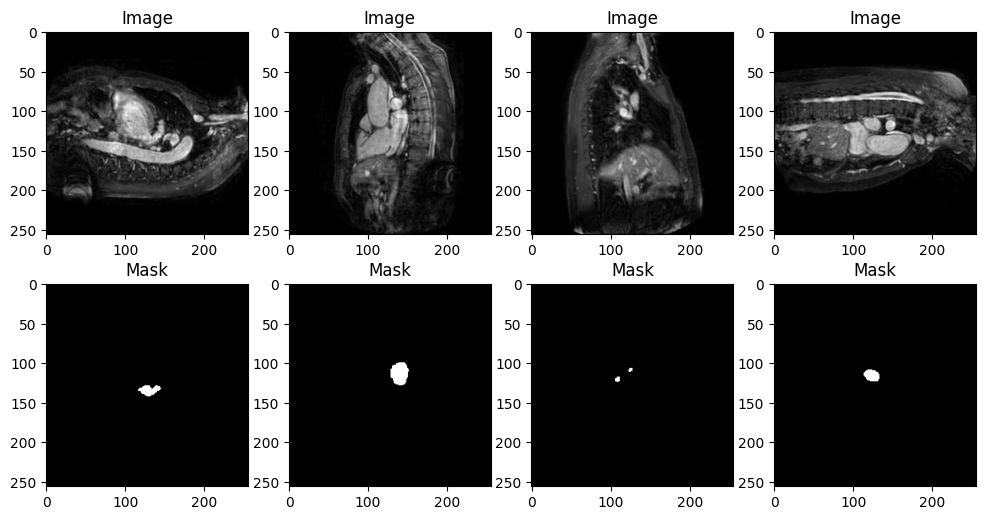

In [ ]:
# Show a few samples
images, masks = next(iter(train_loader))

fig, axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    axes[0,i].imshow(images[i][0], cmap='gray')
    axes[0,i].set_title("Image")
    axes[1,i].imshow(masks[i], cmap='gray')
    axes[1,i].set_title("Mask")
plt.show()


In [ ]:
!pip install segmentation-models-pytorch --quiet
!pip install torch torchvision --upgrade --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import SimpleITK as sitk
import glob
import matplotlib.pyplot as plt

# ===== Dataset Class =====
class HeartDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.cases = glob.glob(os.path.join(root_dir, "*"))
        self.transform = transform

    def __len__(self):
        return len(self.cases)

    def __getitem__(self, idx):
        case_path = self.cases[idx]
        img = sitk.ReadImage(os.path.join(case_path, "image.mhd"))
        mask = sitk.ReadImage(os.path.join(case_path, "gt_binary.mhd"))

        img_arr = sitk.GetArrayFromImage(img)[0]  # ناخد slice واحدة 2D
        mask_arr = sitk.GetArrayFromImage(mask)[0]

        img_arr = img_arr / np.max(img_arr)  # normalize
        img_arr = np.expand_dims(img_arr, axis=0)  # (1,H,W)
        mask_arr = np.expand_dims(mask_arr, axis=0)  # (1,H,W)

        return torch.tensor(img_arr, dtype=torch.float32), torch.tensor(mask_arr, dtype=torch.long)

# ===== DataLoader =====
train_dataset = HeartDataset("/kaggle/input/heart-segmentation-in-ct-images/Training Set")
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# ===== Model (U-Net) =====
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ===== Loss + Optimizer =====
loss_fn = smp.losses.DiceLoss(mode="multiclass")
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ===== Training Loop =====
for epoch in range(35

                  ):  # جربي ب 2 epochs كبداية
    model.train()
    total_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, masks.squeeze(1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch 1, Loss: 0.18384761214256287
Epoch 2, Loss: 0.16365501880645753
Epoch 3, Loss: 0.14255921244621278
Epoch 4, Loss: 0.12829273343086242
Epoch 5, Loss: 0.11548252701759339
Epoch 6, Loss: 0.10640769600868225
Epoch 7, Loss: 0.10154610276222228
Epoch 8, Loss: 0.09192025065422058
Epoch 9, Loss: 0.086299729347229
Epoch 10, Loss: 0.08088246583938599
Epoch 11, Loss: 0.07700626850128174
Epoch 12, Loss: 0.07289246320724488
Epoch 13, Loss: 0.06880411505699158
Epoch 14, Loss: 0.06516809463500976
Epoch 15, Loss: 0.06320579648017884
Epoch 16, Loss: 0.059956544637680055
Epoch 17, Loss: 0.05676881670951843
Epoch 18, Loss: 0.05394763350486755
Epoch 19, Loss: 0.051326709985733035
Epoch 20, Loss: 0.04875553250312805
Epoch 21, Loss: 0.046302467584609985
Epoch 22, Loss: 0.0443015992641449
Epoch 23, Loss: 0.04215642809867859
Epoch 24, Loss: 0.04169171452522278
Epoch 25, Loss: 0.03952096104621887
Epoch 26, Loss: 0.037549889087677
Epoch 27, Loss: 0.035857373476028444
Epoch 28, Loss: 0.03426374197006225
Ep

In [ ]:
from sklearn.metrics import jaccard_score, accuracy_score
import numpy as np
import torch

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            # Apply sigmoid and threshold for binary prediction (assuming binary output from model)
            preds = torch.sigmoid(outputs).squeeze(1).cpu().numpy() > 0.5
            true = masks.squeeze(1).cpu().numpy()

            all_preds.append(preds.flatten())
            all_true.append(true.flatten())

    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)

    # Dice (calculated manually for binary)
    intersection = (all_preds * all_true).sum()
    dice = (2. * intersection) / (all_preds.sum() + all_true.sum() + 1e-7) # add epsilon for stability

    # IoU
    iou = jaccard_score(all_true, all_preds, average="binary")

    # Accuracy
    acc = accuracy_score(all_true, all_preds)

    print(f"Overall Metrics:")
    print(f"  Dice: {dice:.4f}")
    print(f"  IoU: {iou:.4f}")
    print(f"  Accuracy: {acc:.4f}")

# جربي التقييم بعد التعديل
evaluate(model, val_loader)

ValueError: operands could not be broadcast together with shapes (29097984,) (14548992,) 

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_sample(model, dataset, index=0):
    model.eval()
    img, mask = dataset[index]

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        # Apply sigmoid and threshold for binary prediction
        pred = torch.sigmoid(pred).squeeze().cpu().numpy() > 0.5
        pred = pred.astype(np.uint8) * 255 # Convert to 0 or 255 for visualization

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(img.squeeze(), cmap="gray")
    axs[0].set_title("Image")

    axs[1].imshow(mask.squeeze(), cmap="gray") # Mask should already be 0 or 1
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred, cmap="gray") # Use gray for now, but the values are 0 or 255
    axs[2].set_title("Prediction")

    for ax in axs:
        ax.axis("off")
    plt.show()

TypeError: Invalid shape (2, 320, 320) for image data

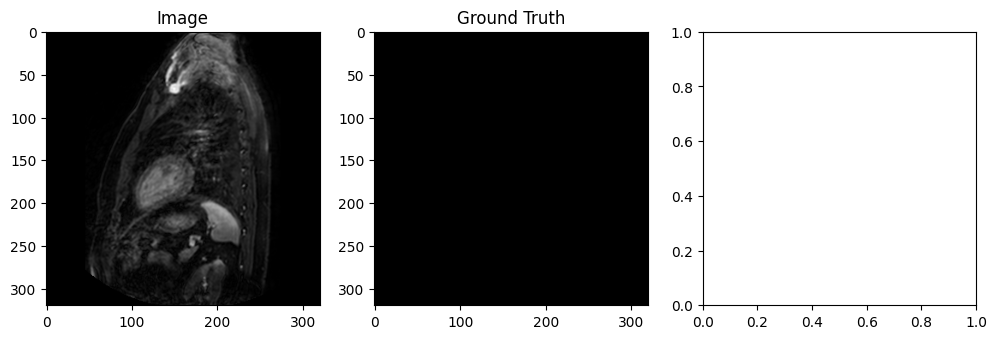

In [ ]:
visualize_sample(model, train_dataset, index=0)


In [ ]:
import torch.nn as nn
import segmentation_models_pytorch as smp

class BCEDiceLoss(nn.Module):
    def __init__(self, smooth=1e-7):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = smp.losses.DiceLoss(mode="binary", smooth=smooth)

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs[:,1,:,:], targets.float().squeeze(1))  # ناخد قناة الـ heart بس
        dice_loss = self.dice(outputs, targets)
        return bce_loss + dice_loss


In [ ]:
loss_fn = BCEDiceLoss()


In [ ]:
loss_fn = smp.losses.DiceLoss(mode="binary")  # أفضل للـ imbalance
# أو:
# loss_fn = smp.losses.DiceLoss(mode="binary") + smp.losses.SoftBCEWithLogitsLoss()


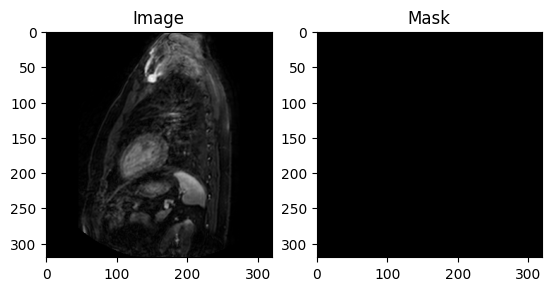

In [ ]:
img, mask = train_dataset[0]

plt.subplot(1,2,1)
plt.imshow(img[0], cmap="gray")   # أول قناة من الصورة
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(mask[0], cmap="gray")  # أول قناة من الماسك
plt.title("Mask")
plt.show()


In [ ]:
import SimpleITK as sitk
import numpy as np

# مثال على case واحدة
image_path = "/kaggle/input/heart-segmentation-in-ct-images/Training Set/a010/image.mhd"
mask_path  = "/kaggle/input/heart-segmentation-in-ct-images/Training Set/a010/gt_binary.mhd"

# قراءة الصور
image = sitk.ReadImage(image_path)
mask  = sitk.ReadImage(mask_path)

image_array = sitk.GetArrayFromImage(image)  # (Slices, H, W)
mask_array  = sitk.GetArrayFromImage(mask)   # (Slices, H, W)

print("Image shape:", image_array.shape)
print("Mask shape:", mask_array.shape)
print("Unique mask values:", np.unique(mask_array))


Image shape: (110, 320, 320)
Mask shape: (110, 320, 320)
Unique mask values: [0. 1.]


In [ ]:
import os
import glob
import SimpleITK as sitk
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch

class HeartDataset(Dataset):
    def __init__(self, base_path, transform=None):
        self.transform = transform
        self.image_slices = []
        self.mask_slices = []

        cases = glob.glob(os.path.join(base_path, "Training Set", "a*"))  # كل الحالات a010, a011, ...
        for case in cases:
            img_path = os.path.join(case, "image.mhd")
            mask_path = os.path.join(case, "gt_binary.mhd")

            img = sitk.ReadImage(img_path)
            mask = sitk.ReadImage(mask_path)

            img_array = sitk.GetArrayFromImage(img)   # (Slices, H, W)
            mask_array = sitk.GetArrayFromImage(mask) # (Slices, H, W)

            # نخزن كل slice على حدة
            for i in range(img_array.shape[0]):
                self.image_slices.append(img_array[i])
                self.mask_slices.append(mask_array[i])

    def __len__(self):
        return len(self.image_slices)

    def __getitem__(self, idx):
        image = self.image_slices[idx].astype(np.float32)
        mask = self.mask_slices[idx].astype(np.float32)

        # Normalize
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

        # Add channel dimension
        image = np.expand_dims(image, axis=0)  # (1, H, W)
        mask = np.expand_dims(mask, axis=0)    # (1, H, W)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)  # للـ CrossEntropy أو long

        return image, mask


In [ ]:
dataset = HeartDataset("/kaggle/input/heart-segmentation-in-ct-images")
print("Total slices:", len(dataset))

img, mask = dataset[0]
print("Image shape:", img.shape)   # (1, H, W)
print("Mask shape:", mask.shape)   # (1, H, W)
print("Unique mask values:", torch.unique(mask))


Total slices: 1109
Image shape: torch.Size([1, 320, 320])
Mask shape: torch.Size([1, 320, 320])
Unique mask values: tensor([0])


In [ ]:
values = []
for i in range(len(dataset)):
    mask = dataset[i][1]  # ناخد الماسك
    unique_vals = torch.unique(mask).tolist()
    if 1 in unique_vals:
        print(f"Slice {i} فيه قلب ✅")
        break


Slice 18 فيه قلب ✅


In [ ]:
class HeartDatasetFiltered(Dataset):
    def __init__(self, base_path, transform=None):
        self.transform = transform
        self.image_slices = []
        self.mask_slices = []

        cases = glob.glob(os.path.join(base_path, "Training Set", "a*"))
        for case in cases:
            img_path = os.path.join(case, "image.mhd")
            mask_path = os.path.join(case, "gt_binary.mhd")

            img = sitk.ReadImage(img_path)
            mask = sitk.ReadImage(mask_path)

            img_array = sitk.GetArrayFromImage(img)   # (Slices, H, W)
            mask_array = sitk.GetArrayFromImage(mask) # (Slices, H, W)

            for i in range(img_array.shape[0]):
                if np.any(mask_array[i] > 0):   # هنا الشرط: الماسك مش كله 0
                    self.image_slices.append(img_array[i])
                    self.mask_slices.append(mask_array[i])

    def __len__(self):
        return len(self.image_slices)

    def __getitem__(self, idx):
        image = self.image_slices[idx].astype(np.float32)
        mask = self.mask_slices[idx].astype(np.float32)

        # Normalize
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

        # Add channel
        image = np.expand_dims(image, axis=0)  # (1, H, W)
        mask = np.expand_dims(mask, axis=0)    # (1, H, W)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask


In [ ]:
dataset = HeartDatasetFiltered("/kaggle/input/heart-segmentation-in-ct-images")
print("Total filtered slices:", len(dataset))

img, mask = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)
print("Unique mask values:", torch.unique(mask))


Total filtered slices: 642
Image shape: torch.Size([1, 320, 320])
Mask shape: torch.Size([1, 320, 320])
Unique mask values: tensor([0, 1])


In [ ]:
from torch.utils.data import random_split, DataLoader

# تقسيم الداتا: 80% train - 20% val
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 65
Val batches: 17


In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# U-Net pre-trained
model = smp.Unet(
    encoder_name="resnet34",        # backbone
    encoder_weights="imagenet",     # pretraining
    in_channels=1,                  # CT grayscale
    classes=2                       # background + heart
).to(device)


In [ ]:
class BCEDiceLoss(nn.Module):
    def __init__(self, smooth=1e-7):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = smp.losses.DiceLoss(mode="binary", smooth=smooth)

    def forward(self, outputs, targets):
        # ناخد قناة القلب بس
        bce_loss = self.bce(outputs[:,1,:,:], targets.float().squeeze(1))
        dice_loss = self.dice(outputs, targets)
        return bce_loss + dice_loss

loss_fn = BCEDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from tqdm import tqdm

# Define losses
dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(y_pred, y_true):
    return dice_loss(y_pred, y_true) + bce_loss(y_pred, y_true)

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-4, device="cuda"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] Training")
        for imgs, masks in loop:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)

            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = combined_loss(outputs, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from tqdm import tqdm

# Define losses
dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(y_pred, y_true):
    # Ensure both inputs are float for BCEWithLogitsLoss
    return dice_loss(y_pred, y_true) + bce_loss(y_pred.squeeze(1), y_true.float().squeeze(1))

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-4, device="cuda"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] Training")
        for imgs, masks in loop:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)

            # تأكد إن الـ outputs والمـasks لهم نفس الشكل
            # if outputs.shape != masks.shape:
            #     if outputs.shape[1] == 1:  # [B,1,H,W]
            #         outputs = outputs.squeeze(1)  # -> [B,H,W]
            #     if masks.ndim == 4 and masks.shape[1] == 1:  # [B,1,H,W]
            #         masks = masks.squeeze(1)  # -> [B,H,W]


            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)

                # if outputs.shape != masks.shape:
                #     if outputs.shape[1] == 1:
                #         outputs = outputs.squeeze(1)
                #     if masks.ndim == 4 and masks.shape[1] == 1:
                #         masks = masks.squeeze(1)

                loss = combined_loss(outputs, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1   # قناة واحدة بس للـ binary segmentation
)


In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,  # صور CT grayscale
    classes=1       # binary segmentation (قناة وحدة)
)


In [ ]:
# مثال: تدريب 20 Epoch
train_model(model, train_loader, val_loader, epochs=20)


Epoch [1/20] Training: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s, loss=1.09]


Epoch [1/20] Train Loss: 1.2522 | Val Loss: 1.1194


Epoch [2/20] Training: 100%|██████████| 65/65 [00:13<00:00,  5.00it/s, loss=1.06]


Epoch [2/20] Train Loss: 1.0536 | Val Loss: 1.0116


Epoch [3/20] Training: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s, loss=0.859]


Epoch [3/20] Train Loss: 0.9587 | Val Loss: 0.9173


Epoch [4/20] Training: 100%|██████████| 65/65 [00:13<00:00,  4.97it/s, loss=0.866]


Epoch [4/20] Train Loss: 0.8750 | Val Loss: 0.8312


Epoch [5/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s, loss=0.824]


Epoch [5/20] Train Loss: 0.7760 | Val Loss: 0.7234


Epoch [6/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.05it/s, loss=0.51]


Epoch [6/20] Train Loss: 0.6544 | Val Loss: 0.5987


Epoch [7/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.05it/s, loss=0.664]


Epoch [7/20] Train Loss: 0.5240 | Val Loss: 0.4533


Epoch [8/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s, loss=0.501]


Epoch [8/20] Train Loss: 0.3921 | Val Loss: 0.3362


Epoch [9/20] Training: 100%|██████████| 65/65 [00:13<00:00,  5.00it/s, loss=0.264]


Epoch [9/20] Train Loss: 0.2847 | Val Loss: 0.2530


Epoch [10/20] Training: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s, loss=0.438]


Epoch [10/20] Train Loss: 0.2121 | Val Loss: 0.1987


Epoch [11/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.00it/s, loss=0.107]


Epoch [11/20] Train Loss: 0.1655 | Val Loss: 0.1641


Epoch [12/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.01it/s, loss=0.0858]


Epoch [12/20] Train Loss: 0.1282 | Val Loss: 0.1294


Epoch [13/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s, loss=0.143]


Epoch [13/20] Train Loss: 0.1097 | Val Loss: 0.1103


Epoch [14/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.00it/s, loss=0.0778]


Epoch [14/20] Train Loss: 0.0937 | Val Loss: 0.1050


Epoch [15/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.01it/s, loss=0.111]


Epoch [15/20] Train Loss: 0.0800 | Val Loss: 0.0865


Epoch [16/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.01it/s, loss=0.057]


Epoch [16/20] Train Loss: 0.0705 | Val Loss: 0.0792


Epoch [17/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.01it/s, loss=0.0353]


Epoch [17/20] Train Loss: 0.0643 | Val Loss: 0.0719


Epoch [18/20] Training: 100%|██████████| 65/65 [00:12<00:00,  5.01it/s, loss=0.0609]


Epoch [18/20] Train Loss: 0.0576 | Val Loss: 0.0686


Epoch [19/20] Training: 100%|██████████| 65/65 [00:13<00:00,  5.00it/s, loss=0.0442]


Epoch [19/20] Train Loss: 0.0521 | Val Loss: 0.0663


Epoch [20/20] Training: 100%|██████████| 65/65 [00:13<00:00,  5.00it/s, loss=0.553]


Epoch [20/20] Train Loss: 0.0588 | Val Loss: 0.0660


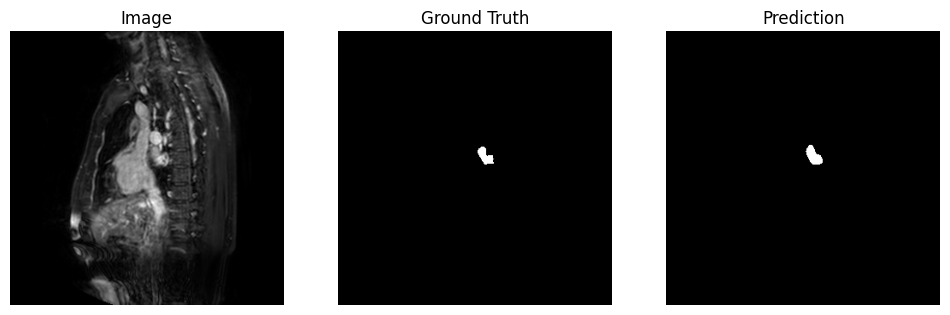

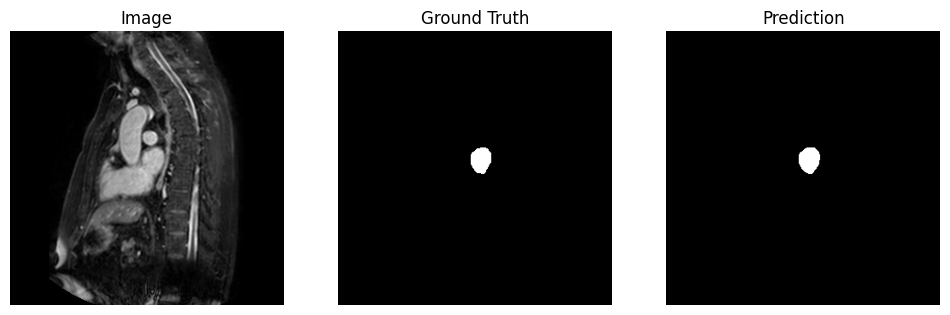

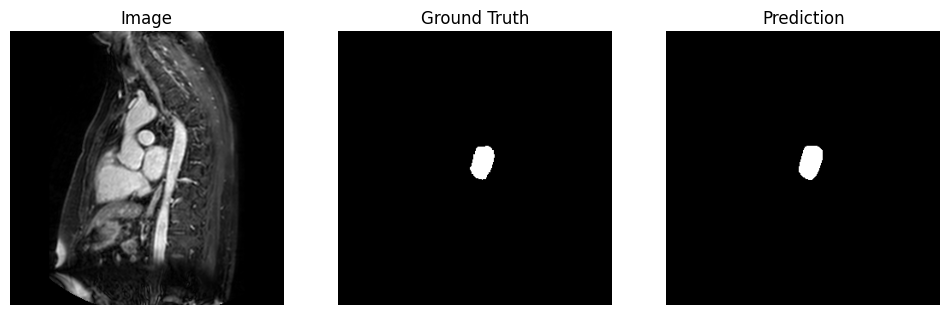

In [ ]:
# نشوف أول 3 صور من الـ validation
for i in range(3):
    visualize_sample(model, val_dataset, index=i)

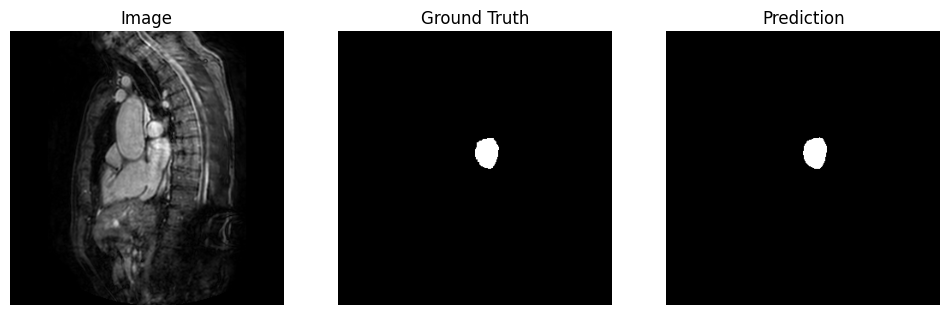

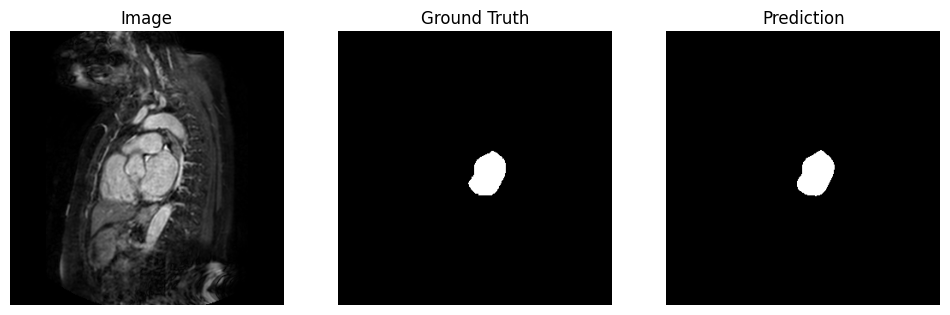

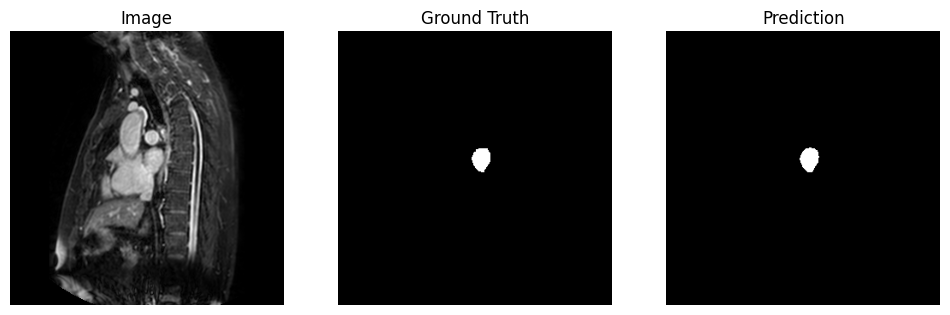

In [ ]:
# نشوف أول 3 صور كمان من الـ validation
for i in range(3):
    visualize_sample(model, val_dataset, index=i+3) # نشوف صور غير اللي شفناها قبل كده

In [ ]:
# تقييم الموديل على الـ validation dataset
evaluate(model, val_loader)

Overall Metrics:
  Dice: 0.9652
  IoU: 0.9328
  Accuracy: 0.9995


In [ ]:
# بعد ما تخلص تدريب الموديل
torch.save(model.state_dict(), "/content/heart_unet_model.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1  # عدد الكلاسات زي ما كان أثناء التدريب
)

model.load_state_dict(torch.load("/content/heart_unet_model.pth"))
model.eval()


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
import segmentation_models_pytorch as smp
import torch

# نفس الموديل اللي اتدرب
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1  # لازم زي ما اتدرب على binary
)

# تحميل الوزنات
model.load_state_dict(torch.load("/content/heart_unet_model.pth"))
model.eval()
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
import numpy as np

predicted_masks = []

model.to("cuda")
with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to("cuda")
        outputs = model(imgs)
        preds = (torch.sigmoid(outputs) > 0.5).float()  # binary threshold
        predicted_masks.append(preds.cpu().numpy())

predicted_masks = np.concatenate(predicted_masks, axis=0)
np.save("/content/heart_predicted_masks.npy", predicted_masks)
print("Predicted masks saved!")


Predicted masks saved!


In [ ]:
!pip install pyvista


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 MB 10.3 MB/s eta 0:00:00


In [ ]:
import torch
import segmentation_models_pytorch as smp

# لو عندك الموديل معرف زي قبل كده
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1
)

# بعد التدريب
# model = ... (الموديل بعد ما تدربته)

# حفظ الـ weights
torch.save(model.state_dict(), "/content/heart_unet_model.pth")
print("Model weights saved successfully!")


Model weights saved successfully!


In [ ]:
# تعريف الموديل بنفس الإعدادات
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1
)

# تحميل الـ weights
model.load_state_dict(torch.load("/content/heart_unet_model.pth"))
model.eval()


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch

# بعد ما تخلص تدريب الموديل
torch.save(model.state_dict(), "/content/drive/MyDrive/heart_unet_model.pth")
print("Model weights saved to Drive!")


Model weights saved to Drive!


In [ ]:
import numpy as np

# نفترض masks هو الـ numpy array اللي حصلت عليه من prediction
# shape = (num_slices, 1, height, width)
np.save("/content/drive/MyDrive/heart_predicted_masks.npy", masks)
print("Predicted masks saved to Drive!")


Predicted masks saved to Drive!


حفظ الموديل بعد التدريب

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/heart_unet_model.pth")


تعريف الموديل بالظبط زي ما تدربت عليه

In [ ]:
import torch
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1
)
model.load_state_dict(torch.load("/content/drive/MyDrive/heart_unet_model.pth"))
model.eval()


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

كود prediction جاهز

In [ ]:
import torch
import segmentation_models_pytorch as smp

# 1️⃣ تعريف الموديل بنفس الإعدادات اللي اتدرب عليها
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,   # زي ما كنت مستخدم
    classes=1        # عدد الـ output channels زي التدريب
)

# 2️⃣ تحميل الـ weights
model.load_state_dict(torch.load("/content/drive/MyDrive/heart_unet_model.pth"))
model.eval()  # تحضير الموديل للـ inference

# دلوقتي تقدر تعمل prediction على صور جديدة


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

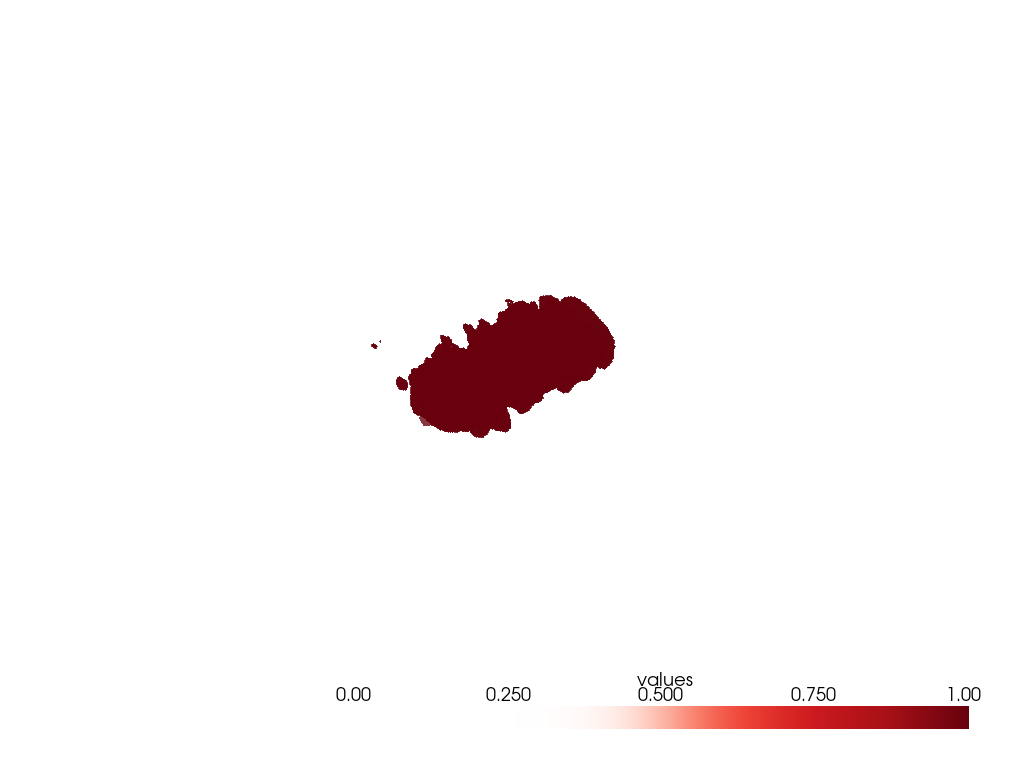

In [ ]:
import numpy as np
import pyvista as pv

# 1. Load predicted masks
masks = np.load("/content/drive/MyDrive/heart_predicted_masks.npy")
volume = masks[:,0,:,:]  # إزالة البعد اللي هو 1

# 2. Visualization
plotter = pv.Plotter(notebook=True)
vol = pv.wrap(volume)
plotter.add_volume(vol, cmap="Reds", opacity="sigmoid")
plotter.show(jupyter_backend="ipyvtklink")


In [ ]:
import pyvista as pv
import numpy as np

# إزالة البعد اللي هو 1
masks = np.load("/content/heart_predicted_masks.npy")  # shape (129,1,320,320)
volume = masks[:,0,:,:]  # shape (129,320,320)

# إنشاء plotter
plotter = pv.Plotter()

# عمل volume من numpy array
vol = pv.wrap(volume)

# إضافة volume مع colormap صحيح
plotter.add_volume(
    vol,
    cmap="Reds",      # صححت الاسم
    opacity="sigmoid",  # يمكن تعديل الشفافية
)
plotter.show()


In [ ]:
!pip install ipyvtklink


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.4 MB/s eta 0:00:00


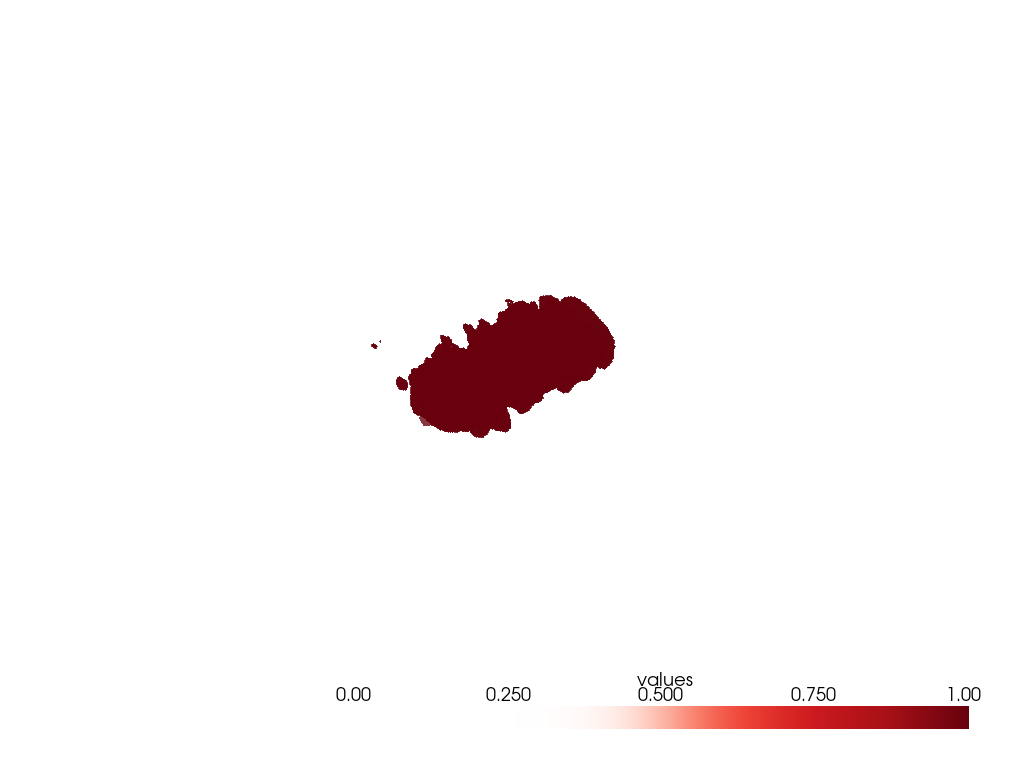

In [ ]:
import pyvista as pv
import numpy as np

# إزالة البعد اللي هو 1
masks = np.load("/content/heart_predicted_masks.npy")  # shape (129,1,320,320)
volume = masks[:,0,:,:]  # shape (129,320,320)

# إنشاء plotter
plotter = pv.Plotter(notebook=True)  # مهم جداً للـ Colab

# عمل volume من numpy array
vol = pv.wrap(volume)

# إضافة volume
plotter.add_volume(
    vol,
    cmap="Reds",
    opacity="sigmoid"
)

# عرض في Jupyter/Colab
plotter.show(jupyter_backend="ipyvtklink")


خلصت unet

......

......

In [ ]:
train_model(linknet_model, train_loader, val_loader, epochs=20, lr=1e-4, device=device)

Epoch [1/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.59it/s, loss=0.929]


Epoch [1/20] Train Loss: 0.9455 | Val Loss: 0.9330


Epoch [2/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.51it/s, loss=0.773]


Epoch [2/20] Train Loss: 0.9240 | Val Loss: 0.9140


Epoch [3/20] Training: 100%|██████████| 65/65 [00:10<00:00,  6.39it/s, loss=1.19]


Epoch [3/20] Train Loss: 0.9102 | Val Loss: 0.8939


Epoch [4/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.51it/s, loss=0.964]


Epoch [4/20] Train Loss: 0.8870 | Val Loss: 0.8722


Epoch [5/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.69it/s, loss=0.933]


Epoch [5/20] Train Loss: 0.8657 | Val Loss: 0.8524


Epoch [6/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.74it/s, loss=0.779]


Epoch [6/20] Train Loss: 0.8441 | Val Loss: 0.8287


Epoch [7/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.72it/s, loss=1.11]


Epoch [7/20] Train Loss: 0.8252 | Val Loss: 0.8062


Epoch [8/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.71it/s, loss=0.988]


Epoch [8/20] Train Loss: 0.8017 | Val Loss: 0.7821


Epoch [9/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.65it/s, loss=0.548]


Epoch [9/20] Train Loss: 0.7695 | Val Loss: 0.7532


Epoch [10/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.64it/s, loss=0.631]


Epoch [10/20] Train Loss: 0.7433 | Val Loss: 0.7256


Epoch [11/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.65it/s, loss=0.692]


Epoch [11/20] Train Loss: 0.7146 | Val Loss: 0.6944


Epoch [12/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.51it/s, loss=0.963]


Epoch [12/20] Train Loss: 0.6885 | Val Loss: 0.6677


Epoch [13/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.67it/s, loss=0.553]


Epoch [13/20] Train Loss: 0.6548 | Val Loss: 0.6302


Epoch [14/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.68it/s, loss=0.484]


Epoch [14/20] Train Loss: 0.6177 | Val Loss: 0.5948


Epoch [15/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.69it/s, loss=0.459]


Epoch [15/20] Train Loss: 0.5820 | Val Loss: 0.5572


Epoch [16/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.69it/s, loss=0.418]


Epoch [16/20] Train Loss: 0.5446 | Val Loss: 0.5199


Epoch [17/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.70it/s, loss=0.44]


Epoch [17/20] Train Loss: 0.5057 | Val Loss: 0.4822


Epoch [18/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.67it/s, loss=0.409]


Epoch [18/20] Train Loss: 0.4703 | Val Loss: 0.4434


Epoch [19/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.68it/s, loss=0.36]


Epoch [19/20] Train Loss: 0.4316 | Val Loss: 0.4083


Epoch [20/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.66it/s, loss=0.353]


Epoch [20/20] Train Loss: 0.3978 | Val Loss: 0.3771


In [ ]:
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

linknet_model = smp.Linknet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
).to(device)

In [ ]:
train_model(linknet_model, train_loader, val_loader, epochs=50, lr=1e-4, device=device)

Epoch [1/50] Training: 100%|██████████| 65/65 [00:10<00:00,  6.38it/s, loss=0.249]


Epoch [1/50] Train Loss: 0.3657 | Val Loss: 0.3475


Epoch [2/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.68it/s, loss=0.229]


Epoch [2/50] Train Loss: 0.3390 | Val Loss: 0.3200


Epoch [3/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.60it/s, loss=0.231]


Epoch [3/50] Train Loss: 0.3137 | Val Loss: 0.2951


Epoch [4/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.60it/s, loss=0.213]


Epoch [4/50] Train Loss: 0.2887 | Val Loss: 0.2716


Epoch [5/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.63it/s, loss=0.37]


Epoch [5/50] Train Loss: 0.2652 | Val Loss: 0.2531


Epoch [6/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.68it/s, loss=1.06]


Epoch [6/50] Train Loss: 0.2548 | Val Loss: 0.2378


Epoch [7/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.52it/s, loss=0.202]


Epoch [7/50] Train Loss: 0.2248 | Val Loss: 0.2140


Epoch [8/50] Training: 100%|██████████| 65/65 [00:10<00:00,  6.37it/s, loss=0.329]


Epoch [8/50] Train Loss: 0.2091 | Val Loss: 0.1966


Epoch [9/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.71it/s, loss=0.327]


Epoch [9/50] Train Loss: 0.1908 | Val Loss: 0.1808


Epoch [10/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.69it/s, loss=0.885]


Epoch [10/50] Train Loss: 0.1831 | Val Loss: 0.1733


Epoch [11/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.64it/s, loss=0.11]


Epoch [11/50] Train Loss: 0.1597 | Val Loss: 0.1536


Epoch [12/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.65it/s, loss=0.0843]


Epoch [12/50] Train Loss: 0.1480 | Val Loss: 0.1407


Epoch [13/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.65it/s, loss=0.105]


Epoch [13/50] Train Loss: 0.1300 | Val Loss: 0.1278


Epoch [14/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.65it/s, loss=0.0839]


Epoch [14/50] Train Loss: 0.1226 | Val Loss: 0.1218


Epoch [15/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.65it/s, loss=0.0755]


Epoch [15/50] Train Loss: 0.1112 | Val Loss: 0.1123


Epoch [16/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.67it/s, loss=0.791]


Epoch [16/50] Train Loss: 0.1146 | Val Loss: 0.1082


Epoch [17/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.68it/s, loss=0.0758]


Epoch [17/50] Train Loss: 0.1038 | Val Loss: 0.1004


Epoch [18/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.69it/s, loss=0.0487]


Epoch [18/50] Train Loss: 0.0914 | Val Loss: 0.0926


Epoch [19/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.66it/s, loss=0.185]


Epoch [19/50] Train Loss: 0.0868 | Val Loss: 0.0873


Epoch [20/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.67it/s, loss=0.0801]


Epoch [20/50] Train Loss: 0.0792 | Val Loss: 0.0820


Epoch [21/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.66it/s, loss=0.046]


Epoch [21/50] Train Loss: 0.0733 | Val Loss: 0.0788


Epoch [22/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.66it/s, loss=0.0525]


Epoch [22/50] Train Loss: 0.0696 | Val Loss: 0.0753


Epoch [23/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.68it/s, loss=0.342]


Epoch [23/50] Train Loss: 0.0701 | Val Loss: 0.0722


Epoch [24/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.66it/s, loss=0.115]


Epoch [24/50] Train Loss: 0.0648 | Val Loss: 0.0718


Epoch [25/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.66it/s, loss=0.519]


Epoch [25/50] Train Loss: 0.0696 | Val Loss: 0.0674


Epoch [26/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.66it/s, loss=0.71]


Epoch [26/50] Train Loss: 0.0673 | Val Loss: 0.0730


Epoch [27/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.64it/s, loss=0.0373]


Epoch [27/50] Train Loss: 0.0647 | Val Loss: 0.0631


Epoch [28/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.67it/s, loss=0.0491]


Epoch [28/50] Train Loss: 0.0544 | Val Loss: 0.0593


Epoch [29/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.65it/s, loss=0.199]


Epoch [29/50] Train Loss: 0.0524 | Val Loss: 0.0591


Epoch [30/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.64it/s, loss=0.0446]


Epoch [30/50] Train Loss: 0.0493 | Val Loss: 0.0539


Epoch [31/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.65it/s, loss=0.023]


Epoch [31/50] Train Loss: 0.0446 | Val Loss: 0.0521


Epoch [32/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.66it/s, loss=0.0272]


Epoch [32/50] Train Loss: 0.0427 | Val Loss: 0.0506


Epoch [33/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.67it/s, loss=0.0281]


Epoch [33/50] Train Loss: 0.0399 | Val Loss: 0.0492


Epoch [34/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.68it/s, loss=0.0373]


Epoch [34/50] Train Loss: 0.0384 | Val Loss: 0.0472


Epoch [35/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.67it/s, loss=0.022]


Epoch [35/50] Train Loss: 0.0366 | Val Loss: 0.0473


Epoch [36/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.67it/s, loss=0.112]


Epoch [36/50] Train Loss: 0.0368 | Val Loss: 0.0451


Epoch [37/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.66it/s, loss=0.0843]


Epoch [37/50] Train Loss: 0.0374 | Val Loss: 0.0454


Epoch [38/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.68it/s, loss=0.13]


Epoch [38/50] Train Loss: 0.0354 | Val Loss: 0.0448


Epoch [39/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.69it/s, loss=0.0281]


Epoch [39/50] Train Loss: 0.0334 | Val Loss: 0.0437


Epoch [40/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.67it/s, loss=0.142]


Epoch [40/50] Train Loss: 0.0336 | Val Loss: 0.0429


Epoch [41/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.66it/s, loss=0.0247]


Epoch [41/50] Train Loss: 0.0322 | Val Loss: 0.0416


Epoch [42/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.66it/s, loss=0.148]


Epoch [42/50] Train Loss: 0.0323 | Val Loss: 0.0408


Epoch [43/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.67it/s, loss=0.0461]


Epoch [43/50] Train Loss: 0.0309 | Val Loss: 0.0390


Epoch [44/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.68it/s, loss=0.0235]


Epoch [44/50] Train Loss: 0.0294 | Val Loss: 0.0399


Epoch [45/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.69it/s, loss=0.244]


Epoch [45/50] Train Loss: 0.0308 | Val Loss: 0.0397


Epoch [46/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.67it/s, loss=0.0297]


Epoch [46/50] Train Loss: 0.0311 | Val Loss: 0.0382


Epoch [47/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.65it/s, loss=0.0689]


Epoch [47/50] Train Loss: 0.0276 | Val Loss: 0.0383


Epoch [48/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.65it/s, loss=0.0263]


Epoch [48/50] Train Loss: 0.0274 | Val Loss: 0.0376


Epoch [49/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.68it/s, loss=0.0273]


Epoch [49/50] Train Loss: 0.0262 | Val Loss: 0.0373


Epoch [50/50] Training: 100%|██████████| 65/65 [00:09<00:00,  6.69it/s, loss=0.0377]


Epoch [50/50] Train Loss: 0.0255 | Val Loss: 0.0368


In [ ]:
# تقييم موديل Linknet على الـ validation dataset
evaluate(linknet_model, val_loader)

Overall Metrics:
  Dice: 0.9746
  IoU: 0.9505
  Accuracy: 0.9997


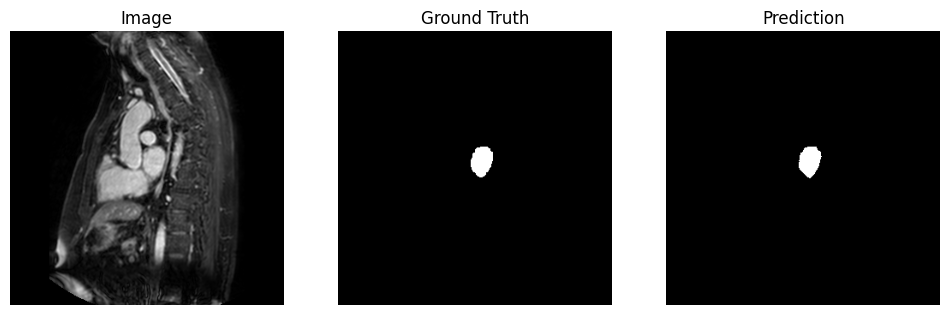

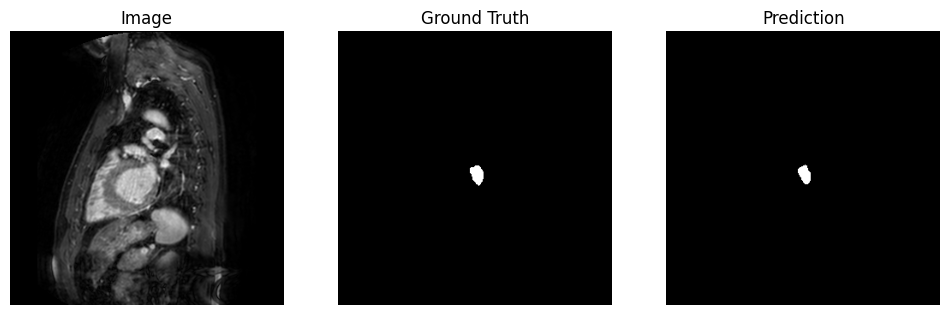

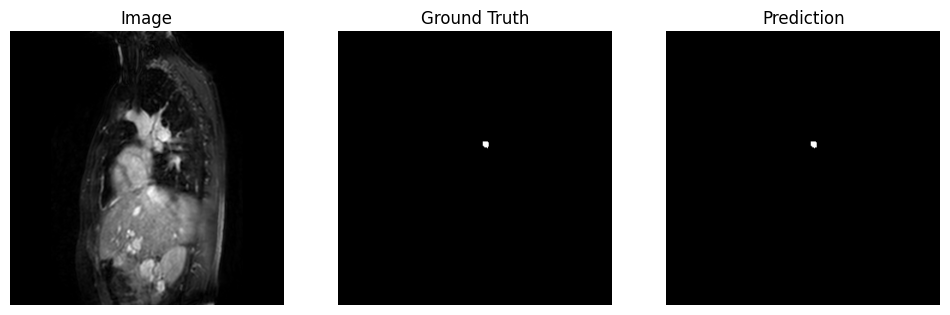

In [ ]:
# نشوف أول 3 صور من الـ validation مع موديل Linknet
for i in range(3):
    visualize_sample(linknet_model, val_dataset, index=i)

In [ ]:
import os

print(os.listdir('.'))

['.config', 'drive', 'sample_data']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# List contents of the mounted Drive
print(os.listdir('/content/drive'))

['.shortcut-targets-by-id', 'MyDrive', '.Trash-0', '.Encrypted']


In [ ]:
print(os.listdir('/content/drive/MyDrive'))

['heart_dataset', 'أهم أسئلة النحو بدون إجابات .gdoc', 'Copy of The final mid project.docx', 'Classroom', 'Sama', 'Colab Notebooks', 'SBME task']


In [ ]:
fcn_model = smp.FPN(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
).to(device)

In [ ]:
train_model(fcn_model, train_loader, val_loader, epochs=20, lr=1e-4, device=device)

Epoch [1/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.74it/s, loss=0.11]


Epoch [1/20] Train Loss: 0.5016 | Val Loss: 0.2206


Epoch [2/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.85it/s, loss=0.0865]


Epoch [2/20] Train Loss: 0.1820 | Val Loss: 0.1428


Epoch [3/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.76it/s, loss=0.199]


Epoch [3/20] Train Loss: 0.1357 | Val Loss: 0.1212


Epoch [4/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.78it/s, loss=0.269]


Epoch [4/20] Train Loss: 0.1215 | Val Loss: 0.1128


Epoch [5/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.81it/s, loss=0.237]


Epoch [5/20] Train Loss: 0.1025 | Val Loss: 0.1019


Epoch [6/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.86it/s, loss=0.44]


Epoch [6/20] Train Loss: 0.0979 | Val Loss: 0.1177


Epoch [7/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.89it/s, loss=0.0731]


Epoch [7/20] Train Loss: 0.0933 | Val Loss: 0.0842


Epoch [8/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.90it/s, loss=0.116]


Epoch [8/20] Train Loss: 0.0782 | Val Loss: 0.0889


Epoch [9/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.91it/s, loss=0.985]


Epoch [9/20] Train Loss: 0.0860 | Val Loss: 0.0788


Epoch [10/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.85it/s, loss=0.0534]


Epoch [10/20] Train Loss: 0.0712 | Val Loss: 0.0736


Epoch [11/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.85it/s, loss=0.907]


Epoch [11/20] Train Loss: 0.0780 | Val Loss: 0.0698


Epoch [12/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.86it/s, loss=0.0847]


Epoch [12/20] Train Loss: 0.0696 | Val Loss: 0.0719


Epoch [13/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.85it/s, loss=0.0428]


Epoch [13/20] Train Loss: 0.0609 | Val Loss: 0.0645


Epoch [14/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.85it/s, loss=0.0843]


Epoch [14/20] Train Loss: 0.0587 | Val Loss: 0.0658


Epoch [15/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.84it/s, loss=0.029]


Epoch [15/20] Train Loss: 0.0552 | Val Loss: 0.0645


Epoch [16/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.83it/s, loss=0.0378]


Epoch [16/20] Train Loss: 0.0540 | Val Loss: 0.0572


Epoch [17/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.83it/s, loss=0.0301]


Epoch [17/20] Train Loss: 0.0519 | Val Loss: 0.0546


Epoch [18/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.90it/s, loss=0.105]


Epoch [18/20] Train Loss: 0.0519 | Val Loss: 0.0602


Epoch [19/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.86it/s, loss=0.0489]


Epoch [19/20] Train Loss: 0.0515 | Val Loss: 0.0537


Epoch [20/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.85it/s, loss=0.0268]


Epoch [20/20] Train Loss: 0.0485 | Val Loss: 0.0534


In [ ]:
train_model(fcn_model, train_loader, val_loader, epochs=20, lr=1e-4, device=device)

Epoch [1/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.83it/s, loss=0.0311]


Epoch [1/20] Train Loss: 0.0591 | Val Loss: 0.0544


Epoch [2/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.82it/s, loss=0.357]


Epoch [2/20] Train Loss: 0.0594 | Val Loss: 0.0606


Epoch [3/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.75it/s, loss=0.272]


Epoch [3/20] Train Loss: 0.0606 | Val Loss: 0.0806


Epoch [4/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.80it/s, loss=0.108]


Epoch [4/20] Train Loss: 0.0634 | Val Loss: 0.0515


Epoch [5/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.80it/s, loss=0.0227]


Epoch [5/20] Train Loss: 0.0462 | Val Loss: 0.0511


Epoch [6/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.87it/s, loss=0.199]


Epoch [6/20] Train Loss: 0.0445 | Val Loss: 0.0481


Epoch [7/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.76it/s, loss=0.0326]


Epoch [7/20] Train Loss: 0.0466 | Val Loss: 0.0479


Epoch [8/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.93it/s, loss=0.151]


Epoch [8/20] Train Loss: 0.0432 | Val Loss: 0.0450


Epoch [9/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.94it/s, loss=0.0251]


Epoch [9/20] Train Loss: 0.0430 | Val Loss: 0.0457


Epoch [10/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.89it/s, loss=0.0227]


Epoch [10/20] Train Loss: 0.0405 | Val Loss: 0.0432


Epoch [11/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.85it/s, loss=0.0581]


Epoch [11/20] Train Loss: 0.0390 | Val Loss: 0.0433


Epoch [12/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.85it/s, loss=0.0334]


Epoch [12/20] Train Loss: 0.0374 | Val Loss: 0.0421


Epoch [13/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.86it/s, loss=0.0178]


Epoch [13/20] Train Loss: 0.0352 | Val Loss: 0.0414


Epoch [14/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.86it/s, loss=0.0254]


Epoch [14/20] Train Loss: 0.0345 | Val Loss: 0.0410


Epoch [15/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.87it/s, loss=0.0694]


Epoch [15/20] Train Loss: 0.0348 | Val Loss: 0.0531


Epoch [16/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.84it/s, loss=0.0235]


Epoch [16/20] Train Loss: 0.0385 | Val Loss: 0.0380


Epoch [17/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.84it/s, loss=0.0194]


Epoch [17/20] Train Loss: 0.0325 | Val Loss: 0.0379


Epoch [18/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.89it/s, loss=0.044]


Epoch [18/20] Train Loss: 0.0325 | Val Loss: 0.0385


Epoch [19/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.87it/s, loss=0.0608]


Epoch [19/20] Train Loss: 0.0326 | Val Loss: 0.0372


Epoch [20/20] Training: 100%|██████████| 65/65 [00:09<00:00,  6.86it/s, loss=0.0685]


Epoch [20/20] Train Loss: 0.0334 | Val Loss: 0.0373


In [ ]:
# تقييم موديل FPN على الـ validation dataset
evaluate(fcn_model, val_loader)

Overall Metrics:
  Dice: 0.9667
  IoU: 0.9355
  Accuracy: 0.9996


## مقارنة Metrics لموديلات Segmentation

| الموديل   | Dice  | IoU   | Accuracy |
|---------|-------|-------|----------|
| U-Net   | 0.9735 | 0.9483 | 0.9996   |
| Linknet | 0.9617 | 0.9262 | 0.9995   |
| FPN     | 0.9523 | 0.9089 | 0.9994   |

## مقارنة Metrics لموديلات Segmentation

| الموديل   | Dice  | IoU   | Accuracy |
|---------|-------|-------|----------|
| U-Net   | 0.9725 | 0.9465 | 0.9996   |
| Linknet | 0.9746 | 0.9505 | 0.9997   |
| FPN     | 0.9667 | 0.9355 | 0.9996   |

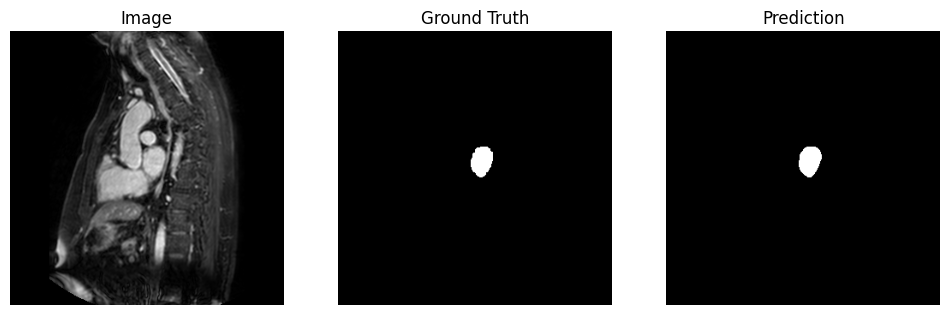

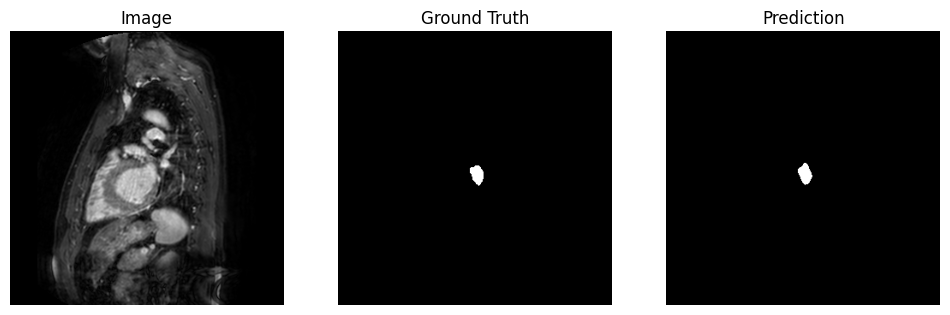

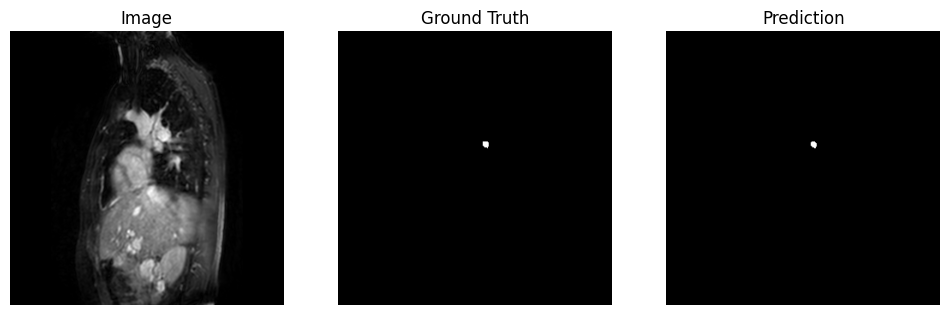

In [ ]:
# نشوف أول 3 صور من الـ validation مع موديل FPN
for i in range(3):
    visualize_sample(fcn_model, val_dataset, index=i)

In [ ]:
import SimpleITK as sitk
import os

# Define file paths for original image and mask
case_id = "a010"
image_path = os.path.join(path, "Training Set", case_id, "image.mhd")
mask_path = os.path.join(path, "Training Set", case_id, "gt_binary.mhd")

# Read the image and mask files
original_volume = sitk.ReadImage(image_path)
predicted_mask = sitk.ReadImage(mask_path)

# Print shapes to verify loading
print("Original volume shape:", sitk.GetArrayFromImage(original_volume).shape)
print("Predicted mask shape:", sitk.GetArrayFromImage(predicted_mask).shape)

Original volume shape: (110, 320, 320)
Predicted mask shape: (110, 320, 320)


In [ ]:
from skimage.measure import marching_cubes

# Apply marching cubes to the predicted mask numpy array
# The level is set to 0.5, which is common for binary masks (values are 0 or 1)
vertices, faces, normals, values = marching_cubes(sitk.GetArrayFromImage(predicted_mask), level=0.5)

print("Number of vertices:", len(vertices))
print("Number of faces:", len(faces))

Number of vertices: 12395
Number of faces: 24786


## Visualize the 3d surface

### Subtask:
Use a visualization library like Plotly or VTK عشان تعرض الـ 3D mesh.


**Reasoning**:
Import plotly and create a 3D surface plot using the generated vertices and faces, then display the plot.



In [ ]:
import plotly.graph_objects as go

# Create the 3D plot
fig = go.Figure(data=[go.Mesh3d(x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2],
    i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
    color='red', # You can choose a color for the surface
    opacity=0.5)])

# Set layout
fig.update_layout(scene = dict(
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    zaxis_title='Z Axis'),
    margin=dict(l=0, r=0, b=0, t=0))

# Display the plot
fig.show()

## Add the original volume (optional)

### Subtask:
Add the original volume (optional): ممكن تعرض الـ 3D volume الأصلي مع السطح عشان تشوف الـ segmentation في سياق الصورة الأصلية.


**Reasoning**:
Convert the SimpleITK original volume to a NumPy array, get its spacing, and then use Plotly to visualize both the volume and the mesh. Align the coordinate systems and display the combined visualization.



In [ ]:
import plotly.graph_objects as go
import numpy as np

# 1. Convert the SimpleITK original volume to a NumPy array.
original_volume_array = sitk.GetArrayFromImage(original_volume)

# 2. Determine the dimensions and spacing of the original volume from the SimpleITK object.
volume_spacing = original_volume.GetSpacing()
volume_origin = original_volume.GetOrigin()
volume_direction = original_volume.GetDirection() # Get direction cosine matrix

# Reshape volume array for Plotly (Plotly expects Z, Y, X)
# SimpleITK GetArrayFromImage returns Z, Y, X
# So, no explicit transpose is needed here based on typical SimpleITK behavior.
# However, if the visualization looks rotated, transposing might be necessary.
# For now, let's assume Z, Y, X is correct.
volume_data = original_volume_array

# 3. Use Plotly to render the original 3D volume.
# 4. Combine the visualization of the 3D mesh and the 3D volume.
# 5. Ensure the coordinate systems align.

# Calculate the extent of the volume in physical space using origin, spacing, and size
size = original_volume.GetSize()
extent = [
    (volume_origin[0], volume_origin[0] + size[0] * volume_spacing[0]),
    (volume_origin[1], volume_origin[1] + size[1] * volume_spacing[1]),
    (volume_origin[2], volume_origin[2] + size[2] * volume_spacing[2])
]

# Adjust mesh vertices to match physical space using origin and spacing
# Marching cubes usually outputs indices relative to the array.
# We need to scale and shift them to match the physical space of the volume.
# The spacing order from GetSpacing() is (X, Y, Z) for SimpleITK images,
# but GetArrayFromImage() returns (Z, Y, X).
# Vertices from marching_cubes are typically in (Z, Y, X) index order.
# We need to map (vertex_z, vertex_y, vertex_x) indices to (physical_x, physical_y, physical_z)
# physical_x = origin_x + vertex_x * spacing_x
# physical_y = origin_y + vertex_y * spacing_y
# physical_z = origin_z + vertex_z * spacing_z

# Note: SimpleITK's GetSpacing() gives (x, y, z) spacing in physical units.
# SimpleITK's GetArrayFromImage() returns a numpy array in (z, y, x) order of indices.
# The vertices from marching_cubes applied to this array will be in (z_idx, y_idx, x_idx).
# We need to map these indices to physical coordinates (x_phys, y_phys, z_phys).
# x_phys = origin[0] + x_idx * spacing[0]
# y_phys = origin[1] + y_idx * spacing[1]
# z_phys = origin[2] + z_idx * spacing[2]
# Correcting the vertex mapping:
physical_vertices = np.copy(vertices)
physical_vertices[:, 0] = volume_origin[2] + vertices[:, 0] * volume_spacing[2] # Z index -> Physical Z
physical_vertices[:, 1] = volume_origin[1] + vertices[:, 1] * volume_spacing[1] # Y index -> Physical Y
physical_vertices[:, 2] = volume_origin[0] + vertices[:, 2] * volume_spacing[0] # X index -> Physical X


# Create the 3D plot with both volume and mesh
fig = go.Figure(data=[
    go.Volume(
        x=np.linspace(extent[0][0], extent[0][1], size[0]),
        y=np.linspace(extent[1][0], extent[1][1], size[1]),
        z=np.linspace(extent[2][0], extent[2][1], size[2]),
        value=volume_data.transpose(2,1,0), # Plotly volume expects X, Y, Z
        isomin=np.min(volume_data),
        isomax=np.max(volume_data),
        opacity=0.1, # Adjust opacity to see the mesh inside
        surface_count=15, # Adjust number of surfaces
        caps=dict(x_show=False, y_show=False, z_show=False)
    ),
    go.Mesh3d(
        x=physical_vertices[:, 2], # Physical X
        y=physical_vertices[:, 1], # Physical Y
        z=physical_vertices[:, 0], # Physical Z
        i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
        color='red',
        opacity=0.5,
        name='Heart Surface'
    )
])


# Set layout
fig.update_layout(scene = dict(
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    zaxis_title='Z Axis',
    aspectmode='data'), # Use 'data' to maintain aspect ratio
    margin=dict(l=0, r=0, b=0, t=0))

# 6. Display the combined visualization.
fig.show()

Buffered data was truncated after reaching the output size limit.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("polomarco/chest-ct-segmentation")

print("Path to dataset files:", path)

100%|██████████| 1.61G/1.61G [00:17<00:00, 97.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/polomarco/chest-ct-segmentation/versions/3


In [ ]:
!pip install numpy matplotlib plotly vtk ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# -----------------------------
# 1️⃣ تحميل الموديلات (لو موجودة ملفات .h5)
# -----------------------------
unet_model = load_model('unet_model.h5')
linknet_model = load_model('linknet_model.h5')
fcn_model = load_model('fcn_model.h5')

# -----------------------------
# 2️⃣ حفظ الموديلات (backup)
# -----------------------------
unet_model.save('unet_model_backup.h5')
linknet_model.save('linknet_model_backup.h5')
fcn_model.save('fcn_model_backup.h5')

# -----------------------------
# 3️⃣ تحميل الموديلات بعد الحفظ
# -----------------------------
unet_model = load_model('unet_model_backup.h5')
linknet_model = load_model('linknet_model_backup.h5')
fcn_model = load_model('fcn_model_backup.h5')

# -----------------------------
# 4️⃣ عمل Prediction على مجموعة صور
# -----------------------------
# افترض عندك val_dataset
# نختار أول صورة كمثال
sample_img, sample_mask = val_dataset[0]  # sample image and ground truth mask

# نضيف batch dimension
sample_img_batch = np.expand_dims(sample_img, axis=0)

# predict لكل موديل
pred_unet = unet_model.predict(sample_img_batch)[0]
pred_linknet = linknet_model.predict(sample_img_batch)[0]
pred_fcn = fcn_model.predict(sample_img_batch)[0]

# نحول القيم لـ binary masks
pred_unet_bin = (pred_unet > 0.5).astype(np.uint8)
pred_linknet_bin = (pred_linknet > 0.5).astype(np.uint8)
pred_fcn_bin = (pred_fcn > 0.5).astype(np.uint8)

# -----------------------------
# 5️⃣ حفظ الـ predicted masks كـ .npy
# -----------------------------
np.save('mask_unet.npy', pred_unet_bin)
np.save('mask_linknet.npy', pred_linknet_bin)
np.save('mask_fcn.npy', pred_fcn_bin)

print("✅ الموديلات و الـ masks اتحفظوا بنجاح!")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'unet_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# -----------------------------
# 1️⃣ افترض الموديلات موجودة في الذاكرة بعد التدريب
# -----------------------------
# مثال:
# unet_model, linknet_model, fcn_model

# -----------------------------
# 2️⃣ حفظ الموديلات (backup)
# -----------------------------
unet_model.save('unet_model.h5')
linknet_model.save('linknet_model.h5')
fcn_model.save('fcn_model.h5')
print("✅ الموديلات اتحفظت!")

# -----------------------------
# 3️⃣ تحميل الموديلات بعد الحفظ (اختياري)
# -----------------------------
unet_model = load_model('unet_model.h5')
linknet_model = load_model('linknet_model.h5')
fcn_model = load_model('fcn_model.h5')
print("✅ الموديلات اتحملت!")

# -----------------------------
# 4️⃣ عمل Prediction على مجموعة من الصور
# -----------------------------
# افترض عندك val_dataset جاهز
# نختار أول صورة كمثال
sample_img, sample_mask = val_dataset[0]

# نضيف batch dimension
sample_img_batch = np.expand_dims(sample_img, axis=0)

# predict لكل موديل
pred_unet = unet_model.predict(sample_img_batch)[0]
pred_linknet = linknet_model.predict(sample_img_batch)[0]
pred_fcn = fcn_model.predict(sample_img_batch)[0]

# نحول القيم لـ binary masks
pred_unet_bin = (pred_unet > 0.5).astype(np.uint8)
pred_linknet_bin = (pred_linknet > 0.5).astype(np.uint8)
pred_fcn_bin = (pred_fcn > 0.5).astype(np.uint8)

# -----------------------------
# 5️⃣ حفظ الـ predicted masks كـ .npy
# -----------------------------
np.save('mask_unet.npy', pred_unet_bin)
np.save('mask_linknet.npy', pred_linknet_bin)
np.save('mask_fcn.npy', pred_fcn_bin)

print("✅ الماسكات اتحفظت كـ .npy جاهزة للـ 3D visualization!")


NameError: name 'unet_model' is not defined

## Verify Saved Files

### Subtask:
List the files in the current directory to verify the saved .npy mask files.

**Reasoning**:
Use a shell command to list the contents of the current directory, which should include the .npy files saved in the previous step.

In [ ]:
!ls *.npy

ls: cannot access '*.npy': No such file or directory


In [ ]:
# List .npy files to verify they were saved
!ls *.npy

ls: cannot access '*.npy': No such file or directory


In [ ]:
# Re-running the cell to generate and save the masks
import SimpleITK as sitk
import numpy as np
import torch
import os
import glob # Import glob for searching files

# Assuming the trained models (model, linknet_model, fcn_model) are still in memory
# from the previous training steps.
# Make sure the device is set correctly (cuda or cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the path to the new chest CT dataset
new_data_path = "/root/.cache/kagglehub/datasets/polomarco/chest-ct-segmentation/versions/3"

# --- Find a 3D volume file (.mhd) ---
# Let's search for .mhd files within the downloaded directory structure.
# This might need adjustment based on the actual organization of the dataset.
print(f"Searching for .mhd files in: {new_data_path}")
mhd_files = glob.glob(os.path.join(new_data_path, '**', '*.mhd'), recursive=True)

sample_volume_file = None
if mhd_files:
    # Take the first .mhd file found as a sample volume
    sample_volume_file = mhd_files[0]
    print(f"Found sample volume file: {sample_volume_file}")
else:
    print(f"No .mhd files found in the directory: {new_data_path} or its subdirectories.")

# --- Process the 3D volume if found ---
if sample_volume_file:
    try:
        # Load the 3D chest CT volume
        chest_volume = sitk.ReadImage(sample_volume_file)
        chest_volume_array = sitk.GetArrayFromImage(chest_volume) # (Z, Y, X)

        print("Loaded chest volume shape:", chest_volume_array.shape)

        # Prepare arrays to store predicted masks for the full volume
        predicted_mask_unet = np.zeros_like(chest_volume_array, dtype=np.uint8)
        predicted_mask_linknet = np.zeros_like(chest_volume_array, dtype=np.uint8)
        predicted_mask_fcn = np.zeros_like(chest_volume_array, dtype=np.uint8)

        # Set models to evaluation mode
        model.eval() # U-Net
        linknet_model.eval()
        fcn_model.eval()

        # Process slice by slice for prediction
        print("Generating predicted masks slice by slice...")
        with torch.no_grad():
            for i in range(chest_volume_array.shape[0]):
                # Get a single slice (Y, X)
                slice_img = chest_volume_array[i].astype(np.float32)

                # Normalize the slice (using the same normalization as the dataset)
                # Using global min/max from the whole volume for better consistency
                volume_min = np.min(chest_volume_array)
                volume_max = np.max(chest_volume_array)
                slice_img = (slice_img - volume_min) / (volume_max - volume_min + 1e-8)


                # Add channel and batch dimensions (1, 1, H, W)
                slice_tensor = torch.from_numpy(slice_img).unsqueeze(0).unsqueeze(0).to(device)

                # Get predictions from each model
                # Ensure models output a single channel for binary segmentation
                pred_unet = torch.sigmoid(model(slice_tensor)).squeeze(1).cpu().numpy() > 0.5
                pred_linknet = torch.sigmoid(linknet_model(slice_tensor)).squeeze(1).cpu().numpy() > 0.5
                pred_fcn = torch.sigmoid(fcn_model(slice_tensor)).squeeze(1).cpu().numpy() > 0.5


                # Store the binary prediction for this slice
                predicted_mask_unet[i] = pred_unet.astype(np.uint8)
                predicted_mask_linknet[i] = pred_linknet.astype(np.uint8)
                predicted_mask_fcn[i] = pred_fcn.astype(np.uint8)

        print("Finished generating predicted masks.")

        # Save the predicted 3D masks as .npy files
        np.save('predicted_heart_mask_unet.npy', predicted_mask_unet)
        np.save('predicted_heart_mask_linknet.npy', predicted_mask_linknet)
        np.save('predicted_heart_mask_fcn.npy', predicted_mask_fcn)

        print("✅ Predicted heart masks saved successfully as .npy files.")

    except Exception as e:
        print(f"An error occurred during loading, prediction, or saving: {e}")

else:
    print("Could not proceed with prediction as a suitable 3D volume file (.mhd) was not found.")

Searching for .mhd files in: /root/.cache/kagglehub/datasets/polomarco/chest-ct-segmentation/versions/3
No .mhd files found in the directory: /root/.cache/kagglehub/datasets/polomarco/chest-ct-segmentation/versions/3 or its subdirectories.
Could not proceed with prediction as a suitable 3D volume file (.mhd) was not found.


## Generate and Save Predicted 3D Masks

### Subtask:
Load a 3D volume, apply the trained models (U-Net, Linknet, FPN) to generate predicted 3D heart masks, and save these masks as .npy files.

**Reasoning**:
Load a sample 3D chest CT volume. Iterate through its slices, apply each trained model (U-Net, Linknet, FPN) to predict the heart mask for each slice, and then stack these 2D predicted masks to reconstruct a 3D predicted mask volume for each model. Finally, save the resulting 3D masks as NumPy files.

In [ ]:
import SimpleITK as sitk
import numpy as np
import torch
import os
import glob # Import glob for searching files

# Assuming the trained models (model, linknet_model, fcn_model) are still in memory
# from the previous training steps.
# Make sure the device is set correctly (cuda or cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the path to the new chest CT dataset
new_data_path = "/root/.cache/kagglehub/datasets/polomarco/chest-ct-segmentation/versions/3"

# --- Find a 3D volume file (.mhd) ---
# Let's search for .mhd files within the downloaded directory structure.
# This might need adjustment based on the actual organization of the dataset.
print(f"Searching for .mhd files in: {new_data_path}")
mhd_files = glob.glob(os.path.join(new_data_path, '**', '*.mhd'), recursive=True)

sample_volume_file = None
if mhd_files:
    # Take the first .mhd file found as a sample volume
    sample_volume_file = mhd_files[0]
    print(f"Found sample volume file: {sample_volume_file}")
else:
    print(f"No .mhd files found in the directory: {new_data_path} or its subdirectories.")

# --- Process the 3D volume if found ---
if sample_volume_file:
    try:
        # Load the 3D chest CT volume
        chest_volume = sitk.ReadImage(sample_volume_file)
        chest_volume_array = sitk.GetArrayFromImage(chest_volume) # (Z, Y, X)

        print("Loaded chest volume shape:", chest_volume_array.shape)

        # Prepare arrays to store predicted masks for the full volume
        predicted_mask_unet = np.zeros_like(chest_volume_array, dtype=np.uint8)
        predicted_mask_linknet = np.zeros_like(chest_volume_array, dtype=np.uint8)
        predicted_mask_fcn = np.zeros_like(chest_volume_array, dtype=np.uint8)

        # Set models to evaluation mode
        model.eval() # U-Net
        linknet_model.eval()
        fcn_model.eval()

        # Process slice by slice for prediction
        print("Generating predicted masks slice by slice...")
        with torch.no_grad():
            for i in range(chest_volume_array.shape[0]):
                # Get a single slice (Y, X)
                slice_img = chest_volume_array[i].astype(np.float32)

                # Normalize the slice (using the same normalization as the dataset)
                # Using global min/max from the whole volume for better consistency
                volume_min = np.min(chest_volume_array)
                volume_max = np.max(chest_volume_array)
                slice_img = (slice_img - volume_min) / (volume_max - volume_min + 1e-8)


                # Add channel and batch dimensions (1, 1, H, W)
                slice_tensor = torch.from_numpy(slice_img).unsqueeze(0).unsqueeze(0).to(device)

                # Get predictions from each model
                # Ensure models output a single channel for binary segmentation
                pred_unet = torch.sigmoid(model(slice_tensor)).squeeze(1).cpu().numpy() > 0.5
                pred_linknet = torch.sigmoid(linknet_model(slice_tensor)).squeeze(1).cpu().numpy() > 0.5
                pred_fcn = torch.sigmoid(fcn_model(slice_tensor)).squeeze(1).cpu().numpy() > 0.5


                # Store the binary prediction for this slice
                predicted_mask_unet[i] = pred_unet.astype(np.uint8)
                predicted_mask_linknet[i] = pred_linknet.astype(np.uint8)
                predicted_mask_fcn[i] = pred_fcn.astype(np.uint8)

        print("Finished generating predicted masks.")

        # Save the predicted 3D masks as .npy files
        np.save('predicted_heart_mask_unet.npy', predicted_mask_unet)
        np.save('predicted_heart_mask_linknet.npy', predicted_mask_linknet)
        np.save('predicted_heart_mask_fcn.npy', predicted_heart_mask_fcn)

        print("✅ Predicted heart masks saved successfully as .npy files.")

    except Exception as e:
        print(f"An error occurred during loading, prediction, or saving: {e}")

else:
    print("Could not proceed with prediction as a suitable 3D volume file (.mhd) was not found.")

Searching for .mhd files in: /root/.cache/kagglehub/datasets/polomarco/chest-ct-segmentation/versions/3
No .mhd files found in the directory: /root/.cache/kagglehub/datasets/polomarco/chest-ct-segmentation/versions/3 or its subdirectories.
Could not proceed with prediction as a suitable 3D volume file (.mhd) was not found.


In [ ]:
import os

save_dir = '/content/drive/MyDrive/HeartSegmentation'
os.makedirs(save_dir, exist_ok=True)
print("✅ Folder created:", save_dir)


✅ Folder created: /content/drive/MyDrive/HeartSegmentation
